In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math

In [149]:
df = pd.read_csv('data/owid_co2_data.csv')
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001733e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [150]:
df = df.filter(['iso_code','year', 'co2', 'population', 'gdp'], axis=1)
df.head()
print('gdp null values: ', df.gdp.isna().sum())

gdp null values:  12520


In [151]:
#Removing null rows that contains null values in co2 column
df = df[df.co2.notna()]

In [152]:
x = df.iso_code.value_counts()
print(x)

OWID_WRL    271
GBR         271
CAN         236
DEU         229
POL         221
           ... 
ATA          21
TLS          19
CXR          14
OWID_KOS     13
PRI           1
Name: iso_code, Length: 219, dtype: int64


In [153]:
#Removing rows with year less than 1950
filtered_df = df.drop(df[df.year < 1950].index)

#Removing rows that refers to the globe
filtered_df = filtered_df.drop(
    filtered_df[filtered_df.iso_code == 'OWID_WRL'].index)

#Since this study consists of the analysis of climate change from 1950
#The countries that appear less than 71 times are not considered because the lack of data
freq_table = filtered_df.iso_code.value_counts()

countries_to_delete = []
for iso_code, value in freq_table.items():
    if value < 71:
        countries_to_delete.append(iso_code)

for iso_code in countries_to_delete:
    filtered_df = filtered_df.drop(filtered_df[filtered_df.iso_code == iso_code].index)
    
x = filtered_df.iso_code.value_counts()
print(x)

AFG    71
SPM    71
NIC    71
NGA    71
PRK    71
       ..
GHA    71
GRC    71
GRL    71
GRD    71
ZWE    71
Name: iso_code, Length: 163, dtype: int64


In [154]:
print('gdp null values: ', filtered_df.gdp.isna().sum())
print('---------------------------------------------')

years = filtered_df.year.value_counts(sort=False, ascending=True)
means = []
for year in years.index:
    means.append(filtered_df[filtered_df.year == year].gdp.mean())

count = 0
indexes = []
for index, mean in enumerate(means):
    if math.isnan(mean):
        count = count + 1
        indexes.append(index)
print('Number of null gdp means: ', count)

#Getting the year of null gdp means
null_years = []
for index in indexes:
    null_years.append(years.index.tolist()[index])
print('Years with null gdp: ', null_years)

#Substitute null values with the nearest year with gdp mean filled
index = years.index.tolist().index(2018)
for year in null_years:
    filtered_df.loc[filtered_df.year == year, 'gdp'] = means[index]

print('gdp null values: ', filtered_df.gdp.isna().sum())

#TODO fare gli altri null values

gdp null values:  4137
---------------------------------------------
Number of null gdp means:  2
Years with null gdp:  [2019, 2020]
gdp null values:  3769


In [155]:
#Caluclate the mean of co2 for each country from 1950 to 2020
iso_codes = filtered_df.iso_code.value_counts()
means = []
for iso_code in iso_codes.index:
    means.append(filtered_df[filtered_df.iso_code == iso_code].co2.mean())
        
means_to_series = pd.Series(means)

#Calculate co2 mean
mean = means_to_series.mean()
print('co2 mean: ', round(mean, 3))
print('---------------------------------------------')

#Calculate co2 median
median = means_to_series.median()
print('co2 median: ', round(median, 3))
print('---------------------------------------------')

#Calculate co2 trimmed mean
co2_sorted = means_to_series.sort_values()
co2_sorted = co2_sorted.reset_index(drop=True)
limit = 0.1
limits = (co2_sorted[round(means_to_series.shape[0]*limit)], 
          co2_sorted[round(means_to_series.shape[0]*(1-limit))])
trimmed_mean = stats.tmean(co2_sorted, limits=limits)
print("co2 trimmed mean:", round(trimmed_mean,2), "with limits:", limits)
print('---------------------------------------------')

#Calculate co2 variance
variance = means_to_series.var()
print('co2 variance: ', round(variance, 3))
print('---------------------------------------------')

#Calculate co2 standard deviation
standard_deviation = means_to_series.std()
print('co2 standard deviation: ', round(standard_deviation, 3))
print('---------------------------------------------')

#Calculate co2 mean absolute deviation
mean_absolute_deviation = means_to_series.mad()
print('co2 mean absolute deviation: ', round(mean_absolute_deviation, 3))
print('---------------------------------------------')

co2 mean:  121.158
---------------------------------------------
co2 median:  11.091
---------------------------------------------
co2 trimmed mean: 34.89 with limits: (0.431492957746479, 254.05183098591544)
---------------------------------------------
co2 variance:  221548.878
---------------------------------------------
co2 standard deviation:  470.69
---------------------------------------------
co2 mean absolute deviation:  171.219
---------------------------------------------


[315.628338028169, 1536.5339014084507, 265.63171830985914, 402.4757887323945, 556.374098591549, 4609.558112676056, 277.9209859154929, 258.0555633802817, 411.61485915492955, 3292.5643661971826, 244.37242253521126, 739.1025070422534, 254.05183098591544, 325.19711267605624, 867.756591549296, 380.9405211267606, 900.7831267605635, 4110.182647887323]
['POL', 'RUS', 'MEX', 'UKR', 'GBR', 'USA', 'ZAF', 'KOR', 'CAN', 'CHN', 'AUS', 'IND', 'IRN', 'ITA', 'JPN', 'FRA', 'DEU', 'Others (146)']


(-1.1149960964001837,
 1.1007140998285803,
 -1.1021304572016029,
 1.1261253147783923)

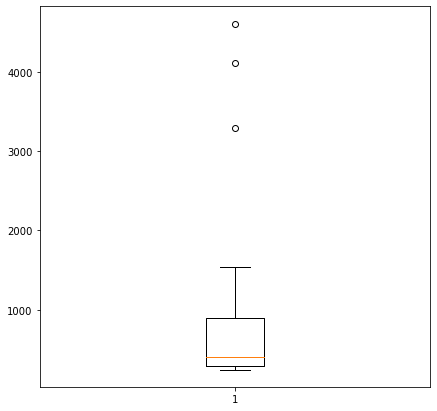

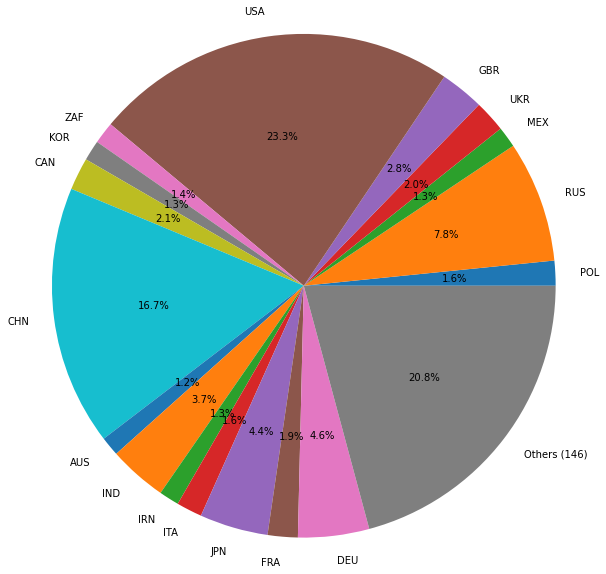

In [161]:
#Graphics
values = []
labels = []
others_value = 0

for index, mean in enumerate(means):
    if mean > 243:
        values.append(mean)
        labels.append(iso_codes.index[index])
    else:
        others_value = others_value + mean

labels.append('Others (' + str(len(means) - len(values)) + ')')
values.append(others_value)
        
print(values)
print(labels)


fig, ax = plt.subplots(figsize=(7, 7))
ax.boxplot(values)

fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(values, labels=labels, autopct='%1.1f%%')
ax1.axis("equal")

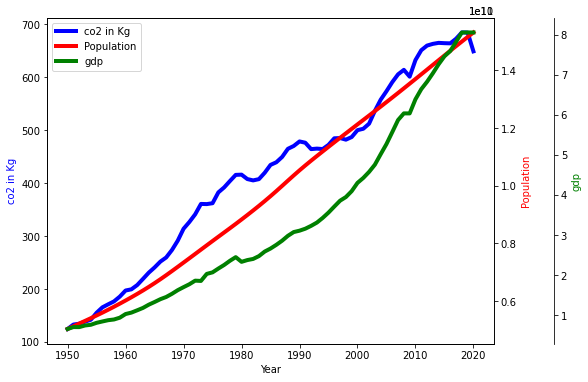

In [157]:
years = filtered_df.year.value_counts(sort=False, ascending=True)

#Calculate co2 mean for each year
co2_means = []
for year in years.index:
    co2_means.append(filtered_df[filtered_df.year == year].co2.mean())

#Calculate gdp mean for each year
gdp_means = []
for year in years.index:
    gdp_means.append(filtered_df[filtered_df.year == year].gdp.mean())

#Calculate population sum for each year
population_sum = []
for year in years.index:
    population_sum.append(filtered_df[filtered_df.year == year].population.sum())

fig, ax_co2 = plt.subplots(figsize=(8,6))
ax_population = ax_co2.twinx()
ax_gdp = ax_co2.twinx()

ax_co2.set_xlabel('Year')
ax_co2.set_ylabel('co2 in Kg')
ax_population.set_ylabel('Population')
ax_gdp.set_ylabel('gdp')

p1, = ax_co2.plot(years.index, co2_means, linewidth=4.0,
                  color='blue', label='co2 in Kg')
p2, = ax_population.plot(years.index, population_sum, linewidth=4.0,    
                         color='red', label='Population')
p3, = ax_gdp.plot(years.index, gdp_means, linewidth=4.0,
                  color='green', label='gdp')

ax_co2.legend(handles=[p1, p2, p3], loc='best')

ax_gdp.spines['right'].set_position(('outward', 60))

ax_co2.yaxis.label.set_color(p1.get_color())
ax_population.yaxis.label.set_color(p2.get_color())
ax_gdp.yaxis.label.set_color(p3.get_color())

Correlation Matrix between co2, population and gdp:

                 co2  population       gdp
co2         1.000000    0.778522  0.719429
population  0.778522    1.000000  0.505114
gdp         0.719429    0.505114  1.000000


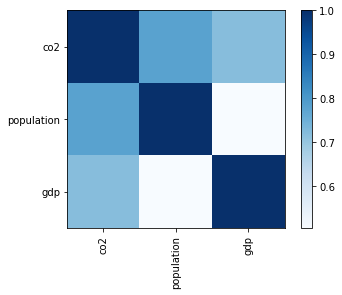

In [158]:
print("Correlation Matrix between co2, population and gdp:\n")
print(filtered_df.loc[:,['co2', 'population', 'gdp']].corr())

df_corr = filtered_df.loc[:,['co2', 'population', 'gdp']]
plt.imshow(df_corr.corr(), cmap = plt.cm.Blues, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(df_corr.columns))]
plt.xticks(tick_marks, df_corr.columns, rotation='vertical')
plt.yticks(tick_marks, df_corr.columns)
plt.show()